In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import toml
import pandas as pd
import seaborn as sns
from qd_analysis.fig import setup_plotting_env
from scipy.stats import mannwhitneyu

## User functions

In [3]:
def get_time_to_baseline(df, cutoff=None):
    _test = df.set_index("days")["value"]
    _index_cut = _test[_test >= cutoff].index
    if len(_index_cut) == 0:
        return np.nan
    else:
        return np.max(_index_cut)

In [4]:
config = toml.load("../preprocessing/config.toml")

In [5]:
fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [6]:
fluo_df = pd.read_parquet(os.path.join(config["dirs"]["data"], "dataframes/fluorescence_intensity_over_time.parquet"))

Note that you need to re-run the notebook 4 times:

1. plt_vars == q1.0 or q1.0_fullframe_bpass (this corresponds to max in mouse roi or mouse over bandpassed full frame)
2. agg_func == q0.95 of mean (this corresponds to 95th percentile across time or average)

In [7]:
plt_vars = ["q1.0_fullframe_bpass"]
agg_func = lambda x: np.quantile(x, 0.95)
agg_func.__name__ = "q.95"
agg_funcs = [agg_func, np.mean]

In [8]:
plt_data = (
    fluo_df.groupby(["days", "subject", "camera", "exp_type"])[plt_vars]
    .agg(agg_funcs)
)

/tmp/ipykernel_195318/2870905186.py:3: FutureWarning: The provided callable <function mean at 0x15552f1d4280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(agg_funcs)


In [9]:
plt_data = plt_data.melt(ignore_index=False, col_level=1, var_name="agg_func").reset_index()

In [10]:
blank_ci = (
    fluo_df.loc[fluo_df["exp_type"].isin(["vehicle", "blank"])]
    .groupby(["subject", "filename"])[plt_vars]
    .agg(agg_funcs)
)

/tmp/ipykernel_195318/4047291581.py:4: FutureWarning: The provided callable <function mean at 0x15552f1d4280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(agg_funcs)


In [11]:
rng = np.random.default_rng(seed=0)

In [12]:
rand_mus = [blank_ci.sample(frac=1, replace=True, random_state=rng).mean() for _ in range(1000)]
rand_mus = pd.DataFrame(rand_mus)

In [13]:
ci_high = rand_mus.quantile(.99)

In [14]:
plt_data.loc[plt_data["exp_type"].isin(["qd_cell_labels", "qd_vascular_labels"]), "exp_class"] = "base_qds"
plt_data.loc[plt_data["exp_type"].isin(["vehicle", "blank"]), "exp_class"] = "ctrl"
plt_data.loc[plt_data["subject"].str.lower().str.contains("qdr_exp"), "exp_class"] = "exposure"
plt_data.loc[plt_data["subject"].str.lower().str.contains("qdr_exp"), "exp_type"] = "exposure"

In [15]:
exclude_subjects = ["qd_beads_01", "qd_beads_02", "qd_beads_03"]

## Fig 1 comparison, qds vs blank/vehicle

In [16]:
setup_plotting_env()

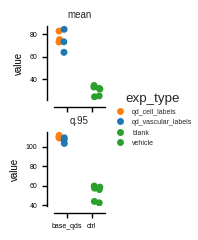

In [17]:
# fig, ax = plt.subplots(1, figsize=(0.9, 1.25))
g = sns.catplot(
    plt_data.query("days==0")
    .groupby(["exp_class", "exp_type", "subject","agg_func"])["value"]
    .mean()
    .reset_index(),
    kind="strip",
    row="agg_func",
    x="exp_class",
    order=["base_qds", "ctrl"],
    hue="exp_type",
    hue_order=["qd_cell_labels", "qd_vascular_labels", "blank", "vehicle"],
    palette={
        "qd_cell_labels": sns.color_palette("tab10")[1],
        "qd_vascular_labels": sns.color_palette("tab10")[0],
        "blank": sns.color_palette("tab10")[2],
        "vehicle": sns.color_palette("tab10")[2],
    },
    y="value",
    dodge=True,
    height=1.25,
    aspect=1.05,
    sharey=False,
)
g.set(xlabel="")
g.set_titles(row_template="{row_name}")
# fig.legend().remove()
# ax.legend(bbox_to_anchor=(1, 0.5))
# g.fig.tight_layout()
sns.despine(offset=5, trim=False)
# fig.savefig(
#     os.path.join(fig_dir, f"qds_v_vehicle_permouse_{agg_func.__name__}_{plt_vars[0]}.pdf"), bbox_inches="tight"
# )

In [18]:
mu = plt_data.query("days==0").groupby(["exp_class", "agg_func", "subject"])["value"].mean()

In [19]:
snr = mu.loc["base_qds"] / mu.loc["ctrl"].mean()

In [20]:
mu.loc["base_qds"]

agg_func  subject   
mean      qd_exp_01      82.583333
          qd_exp_02      75.080645
          qd_exp_03      72.830769
          qd_vasc_01     84.124444
          qd_vasc_02     73.065217
          qd_vasc_03     63.731818
q.95      qd_exp_01     111.470000
          qd_exp_02     108.730000
          qd_exp_03     109.360000
          qd_vasc_01    108.920000
          qd_vasc_02    103.200000
          qd_vasc_03    106.750000
Name: value, dtype: float64

In [21]:
agg_funcs_names = [_.__name__ for _ in agg_funcs]

In [22]:
stat_func = mannwhitneyu
stat_dct = {}
for _func in agg_funcs_names:
    val, pval = stat_func(mu.loc["base_qds",_func], mu.loc["ctrl",_func])
    
    stat_dct[_func] = {
        "test": stat_func.__name__,
        "n": {},
        "statistic": val,
        "pval": pval,
    }

In [23]:
stat_dct

{'q.95': {'test': 'mannwhitneyu',
  'n': {},
  'statistic': 36.0,
  'pval': 0.0021645021645021645},
 'mean': {'test': 'mannwhitneyu',
  'n': {},
  'statistic': 36.0,
  'pval': 0.0021645021645021645}}

In [24]:
for _func in agg_funcs_names:
    mu_agg = mu.xs(_func, level="agg_func")
    for k, v in mu_agg.groupby("exp_class").size().items():
        stat_dct[_func]["n"][k] = v

    stat_dct[_func]["snr"] = {}
    stat_dct[_func]["snr"]["mean"] = snr.loc[_func].mean()
    stat_dct[_func]["snr"]["std"] = snr.loc[_func].std()

In [25]:
with open(os.path.join(fig_dir, f"stats_figure1_{plt_vars}.toml"), "w") as f:
    toml.dump(stat_dct, f)

## Timecourse

In [26]:
setup_plotting_env()

In [27]:
ci_color = "w" if plt.rcParams["axes.facecolor"] == "black" else "k"
# sns.set_context("paper", font_scale=.8)

In [28]:
exclude_subjects = ["qd_beads_01", "qd_beads_02", "qd_beads_03"]

In [29]:
hue_orders = [
    [
        "qd_vascular_labels",
        "qd_cell_labels",
    ],
    [
        "qd_vascular_labels",
        "qd_cell_labels",
        "qd_beads",
    ],
]

In [30]:
base_colors = sns.color_palette("deep")
palette = {
    "qd_vascular_labels": base_colors[0],
    "qd_cell_labels": base_colors[1],
    "qd_beads": base_colors[2],
    "qd_beads_v2": base_colors[3],
    "qd_vascular_labels_high_light": base_colors[3],
}

In [31]:
plt_groups = list(palette.keys())

In [32]:
setup_plotting_env()

In [33]:
plt_vars

['q1.0_fullframe_bpass']

In [34]:
ci_high

q1.0_fullframe_bpass  q.95    60.435833
                      mean    33.883614
Name: 0.99, dtype: float64

60.43583333333334
33.88361423238597


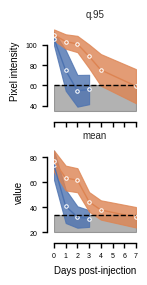

60.43583333333334
33.88361423238597


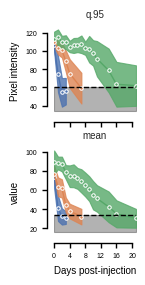

In [35]:
for hue_order in hue_orders:
    g = sns.relplot(
        data=plt_data.query("~subject.isin(@exclude_subjects)"),
        row="agg_func",
        x="days",
        y="value",
        kind="line",
        estimator="mean",
        errorbar=("sd", 1),
        facet_kws={"sharey": False},
        err_kws={"alpha": 0.8},
        palette=palette,
        hue="exp_type",
        hue_order=hue_order,
        marker="o",
        ms=2.5,
        aspect=1.0,
        height=1.4,
        legend=False,
    )
    # g.set(xlim=(0,12))
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    if "qd_beads" not in hue_order[-1]:
        g.set(xlim=(0, 7), xlabel="Days post-injection")
    else:
        g.set(xlim=(0, 21), xlabel="Days post-injection")
    for _ax, _name in zip(g.axes.ravel(), agg_funcs):
        y_boundary = ci_high.loc[plt_vars[0], _ax.get_title()]
        print(y_boundary)
        _ax.axhline(y_boundary, color=ci_color, ls="--")
        xlim = _ax.get_xlim()
        ylim = _ax.get_ylim()
        _ax.fill_between(xlim, ylim[0], y_boundary, alpha=0.3, zorder=-300, color=ci_color)
        _ax.set_xlim(xlim)
        if "qd_beads" not in hue_order[-1]:
            _ax.set_xticks(np.arange(0, xlim[1] + 1, 1))
        else:
            _ax.set_xticks(np.arange(0, xlim[1] + 1, 4))
    g.axes[0][0].set_ylabel("Pixel intensity")
    sns.despine(offset=5, trim=True)
    g.fig.savefig(
        os.path.join(fig_dir, f"qd_fluorescence_decay_{hue_order}_{plt_vars}.pdf"),
        bbox_inches="tight",
    )
    plt.show()

In [36]:
use_cutoff = ci_high[plt_vars[0]]

In [37]:
decay_times = (
    plt_data.query("~subject.isin(@exclude_subjects)")
    .groupby(["exp_type", "subject", "camera", "agg_func"])[["subject", "camera", "days", "value"]]
    .apply(lambda x: get_time_to_baseline(x, use_cutoff.loc[x.name[-1]]))
    .dropna()
    .rename("decay")
    # .reset_index()
)

In [38]:
brightness = (
    plt_data.query("~subject.isin(@exclude_subjects) and days <= 0.0")
    .groupby(["exp_type", "subject", "camera", "agg_func"])["value"]
    .mean()
    .dropna()
    .rename("brightness")
    # .reset_index()
)

In [39]:
plt_data_combined = pd.concat([decay_times, brightness],axis=1)
plt_data_combined = plt_data_combined.melt(ignore_index=False).reset_index()

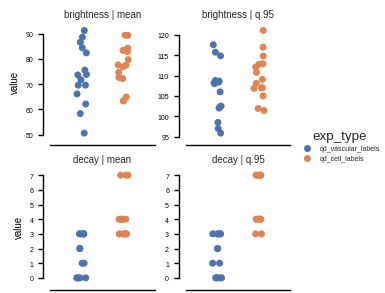

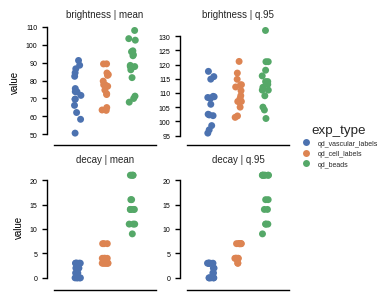

In [40]:
for hue_order in hue_orders:
    g = sns.catplot(
        data=plt_data_combined,
        col="agg_func",
        row="variable",
        row_order=["brightness","decay"],
        y="value",
        hue="exp_type",
        hue_order=hue_order,
        palette=palette,
        dodge=True,
        kind="strip",
        sharey=False,
        height=1.5
    )
    g.set(xticks=[])
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    sns.despine(offset=5, trim=True)
    g.fig.savefig(
        os.path.join(fig_dir, f"qd_fluorescence_decay_rate_brightness_{hue_order}_{plt_vars[0]}.pdf"),
        bbox_inches="tight",
    )

# Looking at conjugation w/ v2

In [41]:
setup_plotting_env()

In [42]:
ci_color = "w" if plt.rcParams["axes.facecolor"] == "black" else "k"
# sns.set_context("paper", font_scale=.8)

In [43]:
blank_ci = fluo_df.query("exp_type == 'vehicle_v2'").groupby(["subject", "filename"])[plt_vars].agg(agg_funcs)

rng = np.random.default_rng(seed=0)

rand_mus = [blank_ci.sample(frac=1, replace=True, random_state=rng).mean() for _ in range(1000)]
rand_mus = pd.DataFrame(rand_mus)

ci_high = rand_mus.quantile(.99)

/tmp/ipykernel_195318/2341640521.py:1: FutureWarning: The provided callable <function mean at 0x15552f1d4280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  blank_ci = fluo_df.query("exp_type == 'vehicle_v2'").groupby(["subject", "filename"])[plt_vars].agg(agg_funcs)


In [44]:
hue_order = [
    "qd_beads_v2",
    "qd_conj_coll_click_v2",
    "qd_conj_fibro_click_v2",
]

In [45]:
palette = sns.color_palette("bright")[2:]

In [46]:
plt.style.use("default")

In [47]:
ci_color = "w" if plt.rcParams["axes.facecolor"] == "black" else "k"

In [48]:
setup_plotting_env()

/tmp/ipykernel_195318/603064536.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


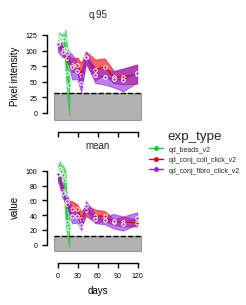

In [49]:
g = sns.relplot(
    data=plt_data.query("~subject.isin(@exclude_subjects)"),
    row="agg_func",
    x="days",
    y="value",
    kind="line",
    estimator="mean",
    errorbar=("sd", 1),
    facet_kws={"sharey": False},
    err_kws={"alpha": 0.6},
    palette=palette,
    hue="exp_type",
    hue_order=hue_order,
    marker="o",
    ms=2.5,
    # mfc="w",
    aspect=1.1,
    height=1.5,
    # height=3,
    # legend=False,
)
# g.set(xlim=(0,12))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
# g.set(xlim=(0,30))
g.axes[0][0].set_ylabel("Pixel intensity")

for _ax, _name in zip(g.axes.ravel(), agg_funcs_names):
    y_boundary = ci_high.loc[plt_vars[0], _name]
    _ax.axhline(y_boundary, color=ci_color, ls="--")
    xlim = _ax.get_xlim()
    ylim = _ax.get_ylim()
    _ax.fill_between(xlim, ylim[0], y_boundary, alpha=0.3, zorder=-300, color=ci_color)
    _ax.set_xlim(xlim)
    _ax.set_xticks(np.arange(0, xlim[1] + 1, 30))

sns.despine(offset=5, trim=True)
g.fig.savefig(
    os.path.join(fig_dir, f"qd_fluorescence_decay_{hue_order}_{plt_vars[0]}_rigv2.pdf"),
    bbox_inches="tight",
)

In [50]:
use_cutoff_v2 = ci_high[plt_vars[0]]

In [51]:
decay_times_v2 = (
    plt_data.query("~subject.isin(@exclude_subjects)")
    .groupby(["exp_type", "subject", "camera", "agg_func"])[["subject", "camera", "days", "value"]]
    .apply(lambda x: get_time_to_baseline(x, use_cutoff_v2.loc[x.name[-1]]))
    .dropna()
    .rename("decay")
    # .dropna()
    # .reset_index()
)

In [52]:
plt_data_combined = pd.concat([decay_times_v2, brightness],axis=1)
plt_data_combined = plt_data_combined.melt(ignore_index=False).reset_index()

/tmp/ipykernel_195318/3352535295.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


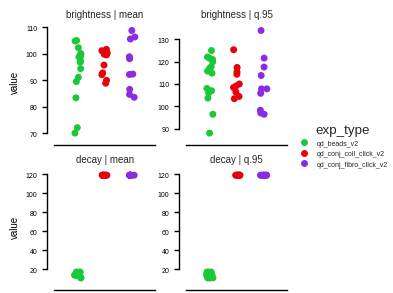

In [53]:
g = sns.catplot(
    data=plt_data_combined,
    col="agg_func",
    row="variable",
    row_order=["brightness","decay"],
    y="value",
    hue="exp_type",
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    kind="strip",
    sharey=False,
    height=1.5
)
g.set(xticks=[])
g.set_titles(row_template="{row_name}", col_template="{col_name}")
sns.despine(offset=5, trim=True)
g.fig.savefig(
    os.path.join(fig_dir, f"qd_fluorescence_decay_rate_brightness_{hue_order}_{plt_vars[0]}.pdf"),
    bbox_inches="tight",
)

# Slightly different brightness calculations for beads_v2 (account for mean better)

In [54]:
agg_func_snr = np.mean

In [55]:
plt_data = (
    fluo_df.groupby(["days", "subject", "camera", "exp_type"])[["std_intensity_fullframe_bpass"]].agg(agg_func_snr)
    # .mean()
)

/tmp/ipykernel_195318/2627372728.py:2: FutureWarning: The provided callable <function mean at 0x15552f1d4280> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fluo_df.groupby(["days", "subject", "camera", "exp_type"])[["std_intensity_fullframe_bpass"]].agg(agg_func_snr)


In [56]:
plt_data = plt_data.melt(ignore_index=False).reset_index()

In [57]:
plt_data.loc[plt_data["exp_type"].isin(["qd_cell_labels", "qd_vascular_labels"]), "exp_class"] = "base_qds"
plt_data.loc[plt_data["exp_type"].isin(["vehicle", "blank"]), "exp_class"] = "ctrl"

In [58]:
brightness_snr = (
    plt_data.query("~subject.isin(@exclude_subjects) and variable == 'std_intensity_fullframe_bpass' and days <= 0.0")
    .groupby(["exp_type", "subject", "camera"])["value"]
    .mean()
    .rename("brightness")
    .reset_index()
)

In [59]:
hue_order = ["qd_vascular_labels", "qd_cell_labels", "qd_beads", "qd_beads_v2"]

In [60]:
baseline = brightness_snr.query("exp_type in ['blank','vehicle']")

In [61]:
baseline_v2 = brightness_snr.query("exp_type in ['vehicle_v2']")

In [62]:
snr_v2 = brightness_snr.query("exp_type.str.contains('v2')")["brightness"] / baseline_v2["brightness"].mean()

In [63]:
brightness_snr["snr"] = brightness_snr["brightness"] / baseline["brightness"].mean()
brightness_snr.loc[snr_v2.index, "snr"] = snr_v2

In [64]:
setup_plotting_env()

In [65]:
# sns.set_context("paper")

/tmp/ipykernel_195318/3605126496.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["var. 1", "var. 2", "var. 3", "var. 3 (rig v2)"])


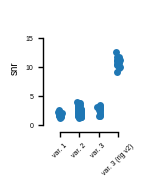

In [66]:
fig, ax = plt.subplots(1, figsize=(1, 1.5))
sns.stripplot(brightness_snr, x="exp_type", y="snr", order=hue_order)
ax.set_yticks(np.arange(0, 20, 5))
ax.set_xticklabels(["var. 1", "var. 2", "var. 3", "var. 3 (rig v2)"])
ax.tick_params(axis="x", rotation=45)
ax.set_xlabel("")
ax.set_ylim(0, 20)
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(fig_dir, "beads_v2_snr_comparison.pdf"), bbox_inches="tight", dpi=600)

In [67]:
stat_func = mannwhitneyu
groups = sorted(
    [
        "qd_cell_labels",
        "qd_vascular_labels",
        "qd_beads",
        "qd_beads_v2",
        "qd_conj_coll_click_v2",
        "qd_conj_fibro_click_v2",
    ]
)
stat_dct = {}
for i, _group1 in enumerate(groups):
    for _group2 in groups[i + 1 :]:
        for _func in agg_funcs_names:
            if _group1 == _group2:
                continue
            dat = decay_times.xs(_func, level="agg_func").reset_index().set_index("exp_type")["decay"]
            dat1 = dat.loc[_group1]
            dat2 = dat.loc[_group2]
            n1 = len(dat1)
            n2 = len(dat2)
            val, pval = stat_func(dat1, dat2)
            subkey = f"{_group1}-{_group2}-{_func}"
            stat_dct[subkey] = {}
            stat_dct[subkey]["decay_time"] = {}
            stat_dct[subkey]["decay_time"]["statistic"] = val
            stat_dct[subkey]["decay_time"]["pval"] = pval
            stat_dct[subkey]["decay_time"]["test"] = stat_func.__name__
            stat_dct[subkey]["decay_time"]["f"] = val / (n1 * n2)
    
            dat = decay_times_v2.xs(_func, level="agg_func").reset_index().set_index("exp_type")["decay"]
            dat1 = dat.loc[_group1]
            dat2 = dat.loc[_group2]
            n1 = len(dat1)
            n2 = len(dat2)
            val, pval = stat_func(dat1, dat2)
            subkey = f"{_group1}-{_group2}-{_func}"
            stat_dct[subkey]["decay_time_v2"] = {}
            stat_dct[subkey]["decay_time_v2"]["statistic"] = val
            stat_dct[subkey]["decay_time_v2"]["pval"] = pval
            stat_dct[subkey]["decay_time_v2"]["test"] = stat_func.__name__
            stat_dct[subkey]["decay_time_v2"]["f"] = val / (n1 * n2)
    
            dat = brightness.xs(_func, level="agg_func").reset_index().set_index("exp_type")["brightness"]
            dat1 = dat.loc[_group1]
            dat2 = dat.loc[_group2]
            n1 = len(dat1)
            n2 = len(dat2)
            val, pval = stat_func(dat1, dat2)
            subkey = f"{_group1}-{_group2}-{_func}"
            stat_dct[subkey]["brightness"] = {}
            stat_dct[subkey]["brightness"]["statistic"] = val
            stat_dct[subkey]["brightness"]["pval"] = pval
            stat_dct[subkey]["brightness"]["test"] = stat_func.__name__
            stat_dct[subkey]["brightness"]["f"] = val / (n1 * n2)
    
            dat = brightness_snr.reset_index().set_index("exp_type")["snr"]
            dat1 = dat.loc[_group1]
            dat2 = dat.loc[_group2]
            n1 = len(dat1)
            n2 = len(dat2)
            val, pval = stat_func(dat1, dat2)
            subkey = f"{_group1}-{_group2}-{_func}"
            stat_dct[subkey]["brightness_snr"] = {}
            stat_dct[subkey]["brightness_snr"]["statistic"] = val
            stat_dct[subkey]["brightness_snr"]["pval"] = pval
            stat_dct[subkey]["brightness_snr"]["test"] = stat_func.__name__
            stat_dct[subkey]["brightness_snr"]["f"] = val / (n1 * n2)

# stat_dct = {
#     "test": stat_func.__name__,
#     "n": {},
#     "statistic": val,
#     "pval": pval,
# }

In [68]:
stat_dct["n"] = {}
for k, v in decay_times.xs("mean", level="agg_func").groupby("exp_type").size().items():
    stat_dct["n"][k] = v

In [69]:
decay_times_summary_dict = (
    decay_times.rename("decay").reset_index().groupby(["exp_type", "agg_func"])["decay"].agg(["mean", "std"]).to_dict()
)
brightness_summary_dict = (
    brightness.rename("brightness")
    .reset_index()
    .groupby(["exp_type", "agg_func"])["brightness"]
    .agg(["mean", "std"])
    .to_dict()
)
decay_times_v2_summary_dict = (
    decay_times_v2.rename("decay")
    .reset_index()
    .groupby(["exp_type", "agg_func"])["decay"]
    .agg(["mean", "std"])
    .to_dict()
)
# brightness_v2_summary_dict = brightness_v2.groupby("exp_type")["brightness"].agg(["mean","std"]).to_dict()
snr_summary_dict = brightness_snr.groupby("exp_type")["snr"].agg(["mean", "std"]).to_dict()

In [70]:
stat_dct["decay_times_summary"] = decay_times_summary_dict
stat_dct["brightness_summary"] = brightness_summary_dict
stat_dct["decay_times_v2_summary"] = decay_times_v2_summary_dict
stat_dct["snr_summary"] = snr_summary_dict

In [71]:
def tuple_to_str(dct):
    if isinstance(dct, dict):
        new_dct = {}
        for k, v in dct.items():
            new_key = str(k)
            new_dct[new_key] = tuple_to_str(v)
        return new_dct
    else:
        return dct
    return new_dct

In [72]:
stat_dct = tuple_to_str(stat_dct)

In [73]:
with open(
    os.path.join(fig_dir, f"stats_figure1_brightness_and_decay_{agg_func.__name__}_{plt_vars[0]}.toml"), "w"
) as f:
    toml.dump(stat_dct, f)

# Checking validity of fullframe vs. ROI (does not depend on agg_func or plt_vars)

In [74]:
include_exps = [
    "qd_cell_labels",
    "qd_vascular_labels",
    # "qd_beads",
    # "qd_beads_v2",
]

In [75]:
check_df = fluo_df.query("exp_type.isin(@include_exps) and days > 0")

In [76]:
agg_func = lambda x: np.quantile(x, 0.95)
agg_func.__name__ = "q.95"
use_funcs = ["mean", agg_func]

In [77]:
agg_df = (
    check_df.groupby("filename")[["q1.0", "q1.0_fullframe_bpass", "q1.0_fullframe_raw"]].agg(use_funcs).reset_index()
)

In [78]:
agg_df.columns = ["_".join(_) for _ in agg_df.columns]

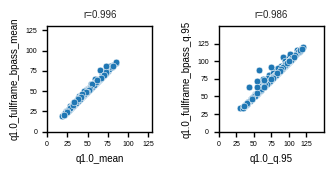

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(3.5, 1.75), sharex=False, sharey=False)
x = "q1.0_mean"
y = "q1.0_fullframe_bpass_mean"
sns.scatterplot(data=agg_df, x=x, y=y, ax=ax[0])
corr1 = agg_df[[x, y]].corr().iloc[0, 1]
ax[0].set_title(f"r={corr1:0.3f}")

x = "q1.0_q.95"
y = "q1.0_fullframe_bpass_q.95"
corr2 = agg_df[[x, y]].corr().iloc[0, 1]

sns.scatterplot(data=agg_df, x=x, y=y, ax=ax[1])
ax[1].set_title(f"r={corr2:0.3f}")
fig.tight_layout()
ticks = np.arange(0, 150, 25)
for _ax in ax:
    _ax.set_xticks(ticks)
    _ax.set_yticks(ticks)
    _ax.set_aspect("equal")
ax[0].set_xlim(0, 130)
ax[0].set_ylim(0, 130)
ax[1].set_xlim(0, 150)
ax[1].set_ylim(0, 150)
fig.savefig(os.path.join(fig_dir, "roi_v_nonroi_scatterplots_with_pearson.pdf"), bbox_inches="tight", dpi=600)